In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)


%matplotlib inline

In [2]:
import sklearn.decomposition
import sklearn.ensemble
from sklearn.model_selection import train_test_split

#### import data loading scripts

In [3]:
from scripts.load_data import *

In [4]:
[X,y]=load_training_spectra()

In [12]:
print(X.columns)
X.head()

Index(['7497.96', '7496.04', '7494.11', '7492.18', '7490.25', '7488.32',
       '7486.39', '7484.46', '7482.54', '7480.61',
       ...
       '617.116', '615.188', '613.259', '611.331', '609.402', '607.474',
       '605.545', '603.617', '601.688', '599.76'],
      dtype='object', length=3578)


,7497.96,7496.04,7494.11,7492.18,7490.25,7488.32,7486.39,7484.46,7482.54,7480.61,...,617.116,615.188,613.259,611.331,609.402,607.474,605.545,603.617,601.688,599.76
0,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,0.298120,...,1.86431,1.84816,1.83288,1.81858,1.80247,1.78462,1.76644,1.75086,1.74335,1.74246
1,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,0.266766,...,1.91071,1.89728,1.88298,1.86131,1.83355,1.80581,1.78410,1.77195,1.76479,1.75437
2,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,0.313296,...,1.77356,1.76544,1.76124,1.75742,1.75113,1.74128,1.72894,1.71991,1.71562,1.71158
3,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,0.257124,...,1.73527,1.72770,1.72349,1.72149,1.71630,1.70737,1.69952,1.69356,1.68812,1.68178
4,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,0.255822,...,1.72088,1.70944,1.69711,1.68257,1.66762,1.65639,1.64929,1.64089,1.62805,1.61643


In [11]:
print(y.columns)
y.head()

Index(['Ca', 'P', 'pH', 'SOC', 'Sand'], dtype='object')


,Ca,P,pH,SOC,Sand
0,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,-0.248601,-0.224635,-0.259551,0.064152,2.091835
3,-0.332195,-0.318014,-0.577548,-0.318719,2.118477
4,-0.438350,-0.010210,-0.699135,-0.310905,2.164148


In [13]:
RFR_model = sklearn.ensemble.RandomForestRegressor(min_impurity_split=1e-5,
                                                       n_estimators=1000,
                                                       min_samples_split=2,
                                                       max_depth=20,
                                                       min_samples_leaf=0.001,
                                                       max_features=0.33,
                                                       n_jobs=-1,
                                                       oob_score=True)

transformed_X = sklearn.decomposition.PCA(n_components=100).fit_transform(X)
RFR_model.fit(transformed_X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.33, max_leaf_nodes=None,
           min_impurity_split=1e-05, min_samples_leaf=0.001,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [14]:
RFR_model.oob_score_

0.658179479678204

### compare model w/ 100 PCs to model w/100 randomly drawn wavenumbers

In [26]:
random_X=X.sample(n=100,axis=1)
random_X.head()
random_X.shape

(1157, 100)

In [27]:
RFR_model.fit(random_X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.33, max_leaf_nodes=None,
           min_impurity_split=1e-05, min_samples_leaf=0.001,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [28]:
RFR_model.oob_score_

0.6533101260840537

### try random forest with all features

In [66]:
RFR_model=sklearn.ensemble.RandomForestRegressor(**params_use,
                                                n_estimators=1000,
                                                 min_samples_leaf=0.001,
                                                  n_jobs=-1,
                                                 oob_score=True)

RFR_model.fit(X,y)
print(RFR_model.oob_score_)

0.648986401775


### Cross-Validation, compressive PCA

In [29]:
n_estimators = 1000

hyperparameter = 'Depth'

#schedule = [1,2,3,5,10,20,30,50,None] #depth

schedule = [1,2,3,5,10,20,]#30,50,None] #depth

#schedule = ['sqrt','auto',0.16,0.33,0.5,0.67] #max_features

#schedule = [2,5,10,20,50,100] #min_samples_split

#schedule = [1e-7,1e-6,1e-5,1e-4,1e-2,1e-1] #min_impurity_split

oob_scores = np.zeros(len(schedule))
inb_scores = np.zeros_like(oob_scores)

for schedule_idx, value in enumerate(schedule):
    RFR_model = sklearn.ensemble.RandomForestRegressor(min_impurity_split=1e-5,
                                                       n_estimators=n_estimators,
                                                       min_samples_split=2,
                                                       max_depth=value,
                                                       min_samples_leaf=0.001,
                                                       max_features=0.33,
                                                       n_jobs=-1,
                                                       oob_score=True)
    
    transformed_X = sklearn.decomposition.PCA(n_components=100,whiten=False).fit_transform(X)
    RFR_model.fit(transformed_X,y)
    oob_scores[schedule_idx] = RFR_model.oob_score_
    inb_scores[schedule_idx] = RFR_model.score(transformed_X,y)

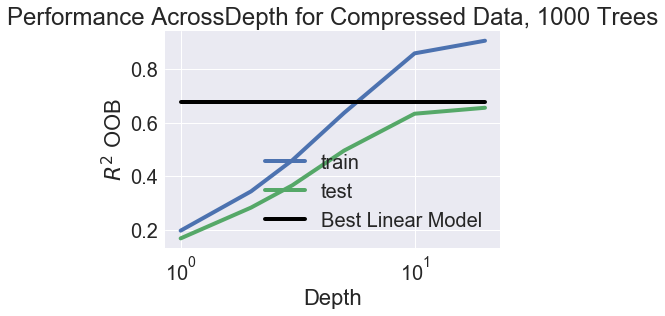

In [30]:
plot_indices = schedule
#plot_indices = list(range(len(schedule))) # for max_features only
plot_indices = schedule
#plot_indices = list(range(len(schedule))) # for max_features only

plt.semilogx(plot_indices,inb_scores,linewidth=4,label='train')
plt.semilogx(plot_indices,oob_scores,linewidth=4,label='test')

plt.semilogx(plot_indices,[0.68]*len(plot_indices),linewidth=4,color='k',label='Best Linear Model')

#plt.xticks(plot_indices,[str(val) for val in schedule]);
plt.xlabel(hyperparameter); plt.ylabel(r'$R^2$ OOB'); plt.legend()
plt.title("Performance Across" + hyperparameter + " for Compressed Data, "+ str(n_estimators)+ " Trees");


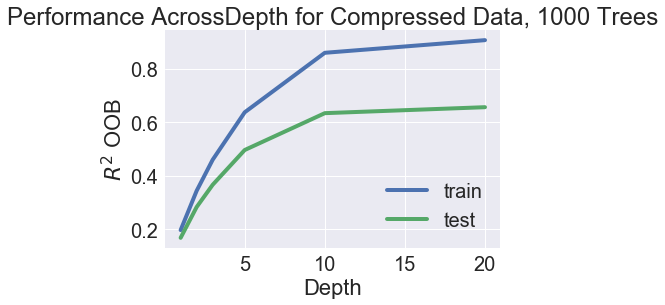

In [31]:
plt.plot(plot_indices,inb_scores,linewidth=4,label='train')
plt.plot(plot_indices,oob_scores,linewidth=4,label='test')

#plt.semilogx(plot_indices,[0.68]*len(plot_indices),linewidth=4,color='k',label='Best Linear Model')

#plt.xticks(plot_indices,[str(val) for val in schedule]);
plt.xlabel(hyperparameter); plt.ylabel(r'$R^2$ OOB'); plt.legend()
plt.title("Performance Across" + hyperparameter + " for Compressed Data, "+ str(n_estimators)+ " Trees");

In [46]:
n_estimators = 1000

hyperparameter = 'max features'

#schedule = [1,2,3,5,10,20,30,50,None] #depth

#schedule = [1,2,3,5,10,20,]#30,50,None] #depth

schedule = ['sqrt','auto',0.16,0.33,0.5,0.67] #max_features

#schedule = [2,5,10,20,50,100] #min_samples_split

#schedule = [1e-7,1e-6,1e-5,1e-4,1e-2,1e-1] #min_impurity_split

oob_scores = np.zeros(len(schedule))
inb_scores = np.zeros_like(oob_scores)
transformed_X = sklearn.decomposition.PCA(n_components=100,whiten=False).fit_transform(X)

for schedule_idx, value in enumerate(schedule):
    RFR_model = sklearn.ensemble.RandomForestRegressor(min_impurity_split=1e-5,
                                                       n_estimators=n_estimators,
                                                       min_samples_split=2,
                                                       max_depth=15,
                                                       min_samples_leaf=0.001,
                                                       max_features=value,
                                                       n_jobs=-1,
                                                       oob_score=True)
    
    
    RFR_model.fit(transformed_X,y)
    oob_scores[schedule_idx] = RFR_model.oob_score_
    inb_scores[schedule_idx] = RFR_model.score(transformed_X,y)

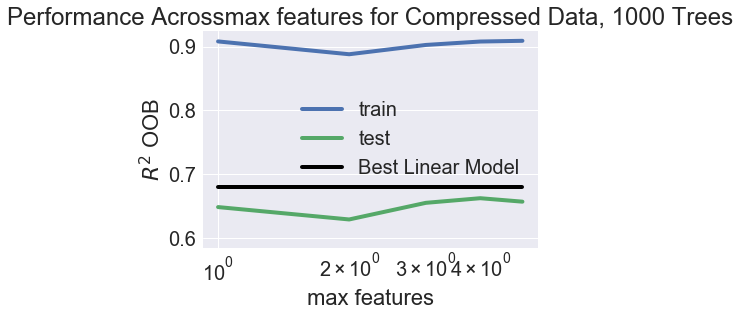

In [48]:
hyperparameter = 'max features'
#plot_indices = schedule
plot_indices = list(range(len(schedule))) # for max_features only

plt.semilogx(plot_indices,inb_scores,linewidth=4,label='train')
plt.semilogx(plot_indices,oob_scores,linewidth=4,label='test')

plt.semilogx(plot_indices,[0.68]*len(plot_indices),linewidth=4,color='k',label='Best Linear Model')

#plt.xticks(plot_indices,[str(val) for val in schedule]);
plt.xlabel(hyperparameter); plt.ylabel(r'$R^2$ OOB'); plt.legend()
plt.title("Performance Across" + hyperparameter + " for Compressed Data, "+ str(n_estimators)+ " Trees");


In [49]:
#n_estimators = 1000

hyperparameter = 'n_estimators'

schedule=[1,10,100,1000,5000,10000]
#schedule = [1,2,3,5,10,20,30,50,None] #depth

#schedule = [1,2,3,5,10,20,]#30,50,None] #depth

#schedule = ['sqrt','auto',0.16,0.33,0.5,0.67] #max_features

#schedule = [2,5,10,20,50,100] #min_samples_split

#schedule = [1e-7,1e-6,1e-5,1e-4,1e-2,1e-1] #min_impurity_split

oob_scores = np.zeros(len(schedule))
inb_scores = np.zeros_like(oob_scores)
transformed_X = sklearn.decomposition.PCA(n_components=100,whiten=False).fit_transform(X)

for schedule_idx, value in enumerate(schedule):
    RFR_model = sklearn.ensemble.RandomForestRegressor(min_impurity_split=1e-5,
                                                       n_estimators=value,
                                                       min_samples_split=2,
                                                       max_depth=15,
                                                       min_samples_leaf=0.001,
                                                       max_features=0.33,
                                                       n_jobs=-1,
                                                       oob_score=True)
    
    
    RFR_model.fit(transformed_X,y)
    oob_scores[schedule_idx] = RFR_model.oob_score_
    inb_scores[schedule_idx] = RFR_model.score(transformed_X,y)

/Applications/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Applications/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


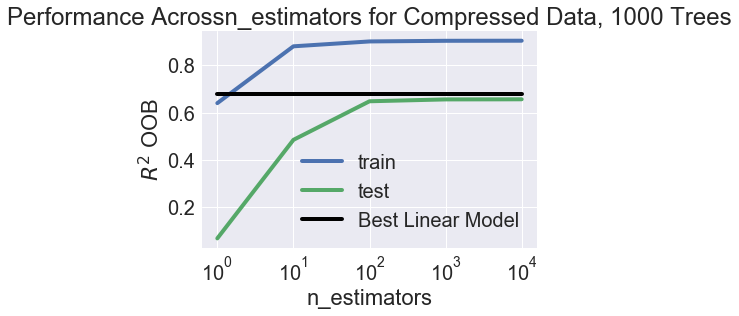

In [50]:

plot_indices = schedule
#plot_indices = list(range(len(schedule))) # for max_features only

plt.semilogx(plot_indices,inb_scores,linewidth=4,label='train')
plt.semilogx(plot_indices,oob_scores,linewidth=4,label='test')

plt.semilogx(plot_indices,[0.68]*len(plot_indices),linewidth=4,color='k',label='Best Linear Model')

#plt.xticks(plot_indices,[str(val) for val in schedule]);
plt.xlabel(hyperparameter); plt.ylabel(r'$R^2$ OOB'); plt.legend()
plt.title("Performance Across" + hyperparameter + " for Compressed Data, "+ str(n_estimators)+ " Trees");

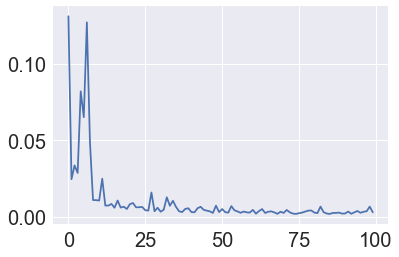

In [45]:
plt.plot(RFR_model.feature_importances_)

### Cross-validation, randomly subsampled data

In [32]:
n_estimators = 1000

hyperparameter = 'Depth'

#schedule = [1,2,3,5,10,20,30,50,None] #depth

schedule = [1,2,3,5,10,20,]#30,50,None] #depth

#schedule = ['sqrt','auto',0.16,0.33,0.5,0.67] #max_features

#schedule = [2,5,10,20,50,100] #min_samples_split

#schedule = [1e-7,1e-6,1e-5,1e-4,1e-2,1e-1] #min_impurity_split

oob_scores = np.zeros(len(schedule))
inb_scores = np.zeros_like(oob_scores)

for schedule_idx, value in enumerate(schedule):
    RFR_model = sklearn.ensemble.RandomForestRegressor(min_impurity_split=1e-5,
                                                       n_estimators=n_estimators,
                                                       min_samples_split=2,
                                                       max_depth=value,
                                                       min_samples_leaf=0.001,
                                                       max_features=0.33,
                                                       n_jobs=-1,
                                                       oob_score=True)
    
    RFR_model.fit(random_X,y)
    oob_scores[schedule_idx] = RFR_model.oob_score_
    inb_scores[schedule_idx] = RFR_model.score(transformed_X,y)

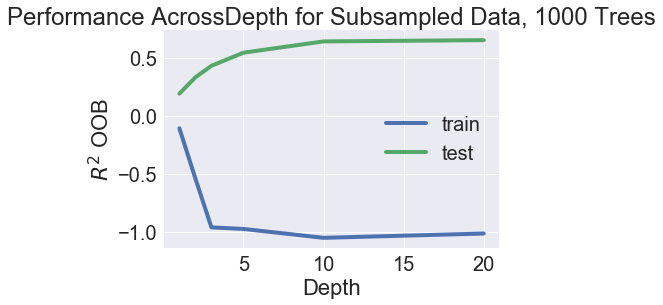

In [35]:
plt.plot(plot_indices,inb_scores,linewidth=4,label='train')
plt.plot(plot_indices,oob_scores,linewidth=4,label='test')

#plt.semilogx(plot_indices,[0.68]*len(plot_indices),linewidth=4,color='k',label='Best Linear Model')

#plt.xticks(plot_indices,[str(val) for val in schedule]);
plt.xlabel(hyperparameter); plt.ylabel(r'$R^2$ OOB'); plt.legend()
plt.title("Performance Across" + hyperparameter + " for Subsampled Data, "+ str(n_estimators)+ " Trees");

### Use random search optimization to find best parameters for this model

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [76]:
results=pd.DataFrame.from_dict(random_search.cv_results_) 
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_impurity_split,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,72.873369,0.315753,-0.254644,0.243613,1,auto,1e-05,20,"{'min_samples_split': 20, 'min_impurity_split'...",19,0.095776,0.207342,-0.109886,0.277577,-0.751107,0.245919,0.880437,0.001923,0.360520,0.028720
1,21.918058,0.317305,-0.242143,0.245116,1,0.16,0.0001,5,"{'min_samples_split': 5, 'min_impurity_split':...",18,0.097743,0.207700,-0.074209,0.281453,-0.751281,0.246195,0.203720,0.000909,0.366343,0.030119
2,52.278701,0.327375,-0.058953,0.425926,2,0.33,1e-06,10,"{'min_samples_split': 10, 'min_impurity_split'...",14,0.175368,0.372717,0.154887,0.460592,-0.508278,0.444468,0.528789,0.000391,0.317419,0.038196
3,435.581850,0.334271,0.057186,0.806662,10,auto,1e-07,20,"{'min_samples_split': 20, 'min_impurity_split'...",7,0.350647,0.807935,0.276885,0.786218,-0.457306,0.825832,20.614107,0.002058,0.364576,0.016197
4,102.221676,0.329033,-0.000334,0.558068,3,0.5,1e-06,5,"{'min_samples_split': 5, 'min_impurity_split':...",10,0.231602,0.513628,0.185933,0.587975,-0.419624,0.572602,1.099967,0.004929,0.296685,0.032045


In [67]:
RFR_model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000,
                                                    n_jobs=-1,
                                                       oob_score=True,
                                                       min_samples_leaf=0.001,
                                                    bootstrap=True)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [1,2,3,5,10,20],
              "max_features": ['sqrt','auto',0.16,0.33,0.5,0.67],
              "min_samples_split": [2,5,10,20,50,100],
              "min_impurity_split": [1e-7,1e-6,1e-5,1e-4,1e-2,1e-1]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(RFR_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 5608.41 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.226 (std: 0.238)
Parameters: {'min_samples_split': 10, 'min_impurity_split': 0.01, 'max_features': 'sqrt', 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.184 (std: 0.218)
Parameters: {'min_samples_split': 10, 'min_impurity_split': 1e-05, 'max_features': 'sqrt', 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.138 (std: 0.329)
Parameters: {'min_samples_split': 5, 'min_impurity_split': 1e-05, 'max_features': 0.16, 'max_depth': 10}



In [70]:
random_search.best_score_


0.22631441979289485

In [57]:
random_search.n_splits_

3

### get score for model with best parameters

In [71]:
random_search.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_impurity_split': 0.01,
 'min_samples_split': 10}

In [72]:
params_use=random_search.best_params_
RFR_model=sklearn.ensemble.RandomForestRegressor(**params_use,
                                                n_estimators=1000,
                                                 min_samples_leaf=0.001,
                                                  n_jobs=-1,
                                                 oob_score=True)

RFR_model.fit(X,y)
print(RFR_model.oob_score_)
    

0.639912466236
